# Spike 

In [7]:
import librosa
import librosa.display
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as play
from os import listdir, path, remove

## Classifier with Spotify Web API

Connect to Spotify Web API using Client Credentials workflow

In [1]:
import requests
import json

#requires Spotify Developer account to access Web API
#requires personal client_id and secret which I have hidden for security purposes
client_id = ''
client_secret = ''
grant_type = 'client_credentials'
body_params = {'grant_type' : grant_type}
url = 'https://accounts.spotify.com/api/token'

response = requests.post(url, data=body_params, auth = (client_id, client_secret))
response.text

'{"access_token":"BQAnizQB09h7OpZ5R9ePsIM2bZF2Cpv4MO0UHZANBDbcusjER-VIY49PWGZ1HYrymkUBMKk5e7iqadprl4U","token_type":"Bearer","expires_in":3600,"scope":""}'

In [2]:
access_token = "BQAnizQB09h7OpZ5R9ePsIM2bZF2Cpv4MO0UHZANBDbcusjER-VIY49PWGZ1HYrymkUBMKk5e7iqadprl4U"
payload = {'Authorization': 'Bearer ' + access_token}

Get Playlists from Spotify and Extract Spotify Features

In [8]:
def get_track_ids(ids):
    url = "https://api.spotify.com/v1/playlists/" + ids + "/tracks"
    r = requests.get(url, headers=payload)
    playlist = r.json()
    track_ids = []
    for track in playlist['items']:
        track_ids.append(track['track']['id'])
    ids_joined = ",".join(track_ids)
    return ids_joined  

In [9]:
def get_track_features(id_list, genre):
    r = requests.get(f"https://api.spotify.com/v1/audio-features/?ids={id_list}", headers=payload)
    features = r.json()
    df = pd.DataFrame(features['audio_features'])
    df['classification'] = genre
    return df

In [10]:
def extract_features(df, feats):
    X = df[feats]
    y = df["classification"]
    return X, y

In [23]:
rhythm_feats = ['tempo', 'time_signature', 'energy', 'danceability']
properties_feats = ['valence', 'instrumentalness', 'speechiness', 'loudness', 'mode', 'key','liveness']
all_feats = ['acousticness', 'liveness', 'valence', 'tempo', 'mode','key','time_signature', 'energy', 'danceability', 'instrumentalness', 'speechiness', 'loudness']

chilled_jazz_id = '37i9dQZF1DX2vYju3i0lNX'
jazz_ids = get_track_ids(chilled_jazz_id)
jazz = get_track_features(jazz_ids, 'Jazz')

# classic_rock_id = "37i9dQZF1DWXRqgorJj26U"
classic_rock_id = "37i9dQZF1DWYE5MI4mMuii"
rock_ids = get_track_ids(classic_rock_id)
rock = get_track_features(rock_ids, 'Rock')

classical_id = "37i9dQZF1DWWEJlAGA9gs0"
classical_ids = get_track_ids(classical_id)
classical = get_track_features(classical_ids, 'Classical')

hiphop_id = "37i9dQZF1DX6J5NfMJS675"
hiphop_ids = get_track_ids(hiphop_id)
hiphop = get_track_features(hiphop_ids, "HipHop")

pop_id = "37i9dQZF1DXcBWIGoYBM5M"
pop_ids = get_track_ids(pop_id)
pop = get_track_features(pop_ids, 'Pop')

genres_df = pd.concat([jazz, rock, pop]) #classical, pop
X_all, y_all = extract_features(genres_df, all_feats)
X_rhythm, y_rhythm = extract_features(genres_df, rhythm_feats)
X_properties, y_properties = extract_features(genres_df, properties_feats)

#### K Nearest Neighbors Model

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

def train_knn(X, y, title):
    # Split Data into Training and Testing Set 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)
    
    # Use Cross Validation to find optimal k value
    cv_scores = []
    for k in range(1, 10):
        nearest_neighbors = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(nearest_neighbors, X_train, y_train, cv=5)
        cv_scores.append(np.mean(scores))
    k_value = np.argmax(cv_scores) + 1
    CV_score = max(cv_scores)
    
    # Train Model Using Optimal K Value 
    nearest_neighbors = KNeighborsClassifier(n_neighbors=k_value)
    nearest_neighbors.fit(X_train, y_train)
    y_pred_train = nearest_neighbors.predict(X_train)
    y_pred_test = nearest_neighbors.predict(X_test)
    
    # Print Training, CV, Test Scores
    print(f"----- {title} -----")
    print(f"Training Score: {accuracy_score(y_train, y_pred_train)}")
    print(f"CV Score: {CV_score}, with k_value: {k_value}")
    print(f"Test Score: {accuracy_score(y_test, y_pred_test)}")
    return nearest_neighbors

    
all_knn_model = train_knn(X_all,y_all, "All Features")
rhythm_knn_model = train_knn(X_rhythm,y_rhythm, "Features Relating to Rhythm")
properties_knn_model = train_knn(X_properties,y_properties, "Features Relating to Music Production")

----- All Features -----
Training Score: 1.0
CV Score: 0.7055555555555555, with k_value: 1
Test Score: 0.6888888888888889
----- Features Relating to Rhythm -----
Training Score: 1.0
CV Score: 0.5555555555555556, with k_value: 1
Test Score: 0.5333333333333333
----- Features Relating to Music Production -----
Training Score: 0.8944444444444445
CV Score: 0.7888888888888889, with k_value: 3
Test Score: 0.8666666666666667


#### Multiclass Logistic Regression

In [25]:
import warnings
warnings.filterwarnings('ignore')
def train_log(X, y, title):
    # Split Data into Training and Testing Set 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)
    
    # Use Cross Validation to Train Model
    cv_scores = []
    for k in range(1, 10):
        lr = LogisticRegression(max_iter=200)
        scores = cross_val_score(lr, X_train, y_train, cv=9)
        cv_scores.append(np.mean(scores))
    CV_score = max(cv_scores)
    
    # Train Model 
    lr = LogisticRegression(max_iter=400)
    lr.fit(X_train, y_train)
    y_pred_train = lr.predict(X_train)
    y_pred_test = lr.predict(X_test)
    
    # Print Training, CV, Test Scores
    print(f"----- {title} -----")
    print(f"Training Score: {accuracy_score(y_train, y_pred_train, )}")
    print(f"CV Score: {CV_score}")
    print(f"Test Score: {accuracy_score(y_test, y_pred_test)}")
    return lr

all_lr_model = train_log(X_all,y_all, "All Features")
rhythm_lr_model = train_log(X_rhythm,y_rhythm, "Features Relating to Rhythm")
properties_lr_model = train_log(X_properties,y_properties, "Features Relating to Music Production")

----- All Features -----
Training Score: 0.9611111111111111
CV Score: 0.9166666666666666
Test Score: 0.9555555555555556
----- Features Relating to Rhythm -----
Training Score: 0.8111111111111111
CV Score: 0.8
Test Score: 0.7333333333333333
----- Features Relating to Music Production -----
Training Score: 0.8944444444444445
CV Score: 0.8555555555555555
Test Score: 0.9333333333333333


In [26]:
def test_new_song(song_id, model, features):
    r = requests.get(f"https://api.spotify.com/v1/audio-features/{song_id}", headers=payload)
    song_features = r.json()
    song_df = pd.DataFrame(song_features, index=[0])
    song_df = song_df[features]
    return model.predict(song_df)[0]
        
giant_steps = "47vmcuvMWFIsMaiHFIGSIu"
print("----- Giant Steps - KNN -----")
print(f"All Features: {test_new_song(giant_steps, all_knn_model, all_feats)}")
print(f"Features Relating to Rhythm: {test_new_song(giant_steps, rhythm_knn_model, rhythm_feats)}")
print(f"Features Relating to Music Production: {test_new_song(giant_steps, properties_knn_model, properties_feats)}")

print("----- Giant Steps - LR -----")
print(f"All Features: {test_new_song(giant_steps, all_lr_model, all_feats)}")
print(f"Features Relating to Rhythm: {test_new_song(giant_steps, rhythm_lr_model, rhythm_feats)}")
print(f"Features Relating to Music Production: {test_new_song(giant_steps, properties_lr_model, properties_feats)}")

livery_stable_blues = "4xR1tOO9p4cnDNmIEttfaZ"
print("----- Livery Stable Blues - KNN -----")
print(f"All Features: {test_new_song(livery_stable_blues, all_knn_model, all_feats)}")
print(f"Features Relating to Rhythm: {test_new_song(livery_stable_blues, rhythm_knn_model, rhythm_feats)}")
print(f"Features Relating to Music Production: {test_new_song(livery_stable_blues, properties_knn_model, properties_feats)}")

print("----- Livery Stable Blues - LR ----- Chang over time!")
print(f"All Features: {test_new_song(livery_stable_blues, all_lr_model, all_feats)}")
print(f"Features Relating to Rhythm: {test_new_song(livery_stable_blues, rhythm_lr_model, rhythm_feats)}")
print(f"Features Relating to Music Production: {test_new_song(livery_stable_blues, properties_lr_model, properties_feats)}")

cool_out = "489alJQIWUauqzKTMuXRjm"
print("----- Cool Out - KNN -----")
print(f"All Features: {test_new_song(cool_out, all_knn_model, all_feats)}")
print(f"Features Relating to Rhythm: {test_new_song(cool_out, rhythm_knn_model, rhythm_feats)}")
print(f"Features Relating to Music Production: {test_new_song(cool_out, properties_knn_model, properties_feats)}")

print("----- Cool Out - LR -----")
print(f"All Features: {test_new_song(cool_out, all_lr_model, all_feats)}")
print(f"Features Relating to Rhythm: {test_new_song(cool_out, rhythm_lr_model, rhythm_feats)}")
print(f"Features Relating to Music Production: {test_new_song(cool_out, properties_lr_model, properties_feats)}")

positions = "35mvY5S1H3J2QZyna3TFe0"
print("----- Positions - KNN -----")
print(f"All Features: {test_new_song(positions, all_knn_model, all_feats)}")
print(f"Features Relating to Rhythm: {test_new_song(positions, rhythm_knn_model, rhythm_feats)}")
print(f"Features Relating to Music Production: {test_new_song(positions, properties_knn_model, properties_feats)}")

print("----- Positions - LR -----")
print(f"All Features: {test_new_song(positions, all_lr_model, all_feats)}")
print(f"Features Relating to Rhythm: {test_new_song(positions, rhythm_lr_model, rhythm_feats)}")
print(f"Features Relating to Music Production: {test_new_song(positions, properties_lr_model, properties_feats)}")

----- Giant Steps - KNN -----
All Features: Rock
Features Relating to Rhythm: Rock
Features Relating to Music Production: Rock
----- Giant Steps - LR -----
All Features: Rock
Features Relating to Rhythm: Rock
Features Relating to Music Production: Rock
----- Livery Stable Blues - KNN -----
All Features: Rock
Features Relating to Rhythm: Rock
Features Relating to Music Production: Rock
----- Livery Stable Blues - LR -----
All Features: Rock
Features Relating to Rhythm: Rock
Features Relating to Music Production: Jazz
----- Cool Out - KNN -----
All Features: Jazz
Features Relating to Rhythm: Pop
Features Relating to Music Production: Jazz
----- Cool Out - LR -----
All Features: Jazz
Features Relating to Rhythm: Jazz
Features Relating to Music Production: Jazz
----- Positions - KNN -----
All Features: Pop
Features Relating to Rhythm: Pop
Features Relating to Music Production: Pop
----- Positions - LR -----
All Features: Pop
Features Relating to Rhythm: Rock
Features Relating to Music Prod

## Onset Attacks - see how different modern day jazz really is 

In [126]:
def plot(sample, sr, name):
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(sample)), ref=np.max)
    img = librosa.display.specshow(D, y_axis='linear', x_axis='s',
                                   sr=sr, ax=ax[0])
    plot_title = name + " Linear-frequency power spectrogram"
    ax[0].set(title=plot_title)
    ax[0].label_outer()

    librosa.display.waveplot(sample, sr=sr, ax=ax[1], x_axis='s')
    ax[1].set(title='Stereo')
    ax[1].label_outer()

def onsets(sample, sr):
    onset_frames = librosa.onset.onset_detect(sample, sr=sr, wait=1, pre_avg=1, post_avg=1, pre_max=1, post_max=1)
    onset_times = librosa.frames_to_time(onset_frames)
    onset_clicks = librosa.clicks(frames=onset_frames, sr=sr, length=len(sample))
    return onset_times, onset_clicks

def normalize(onset_times):
    start_time = onset_times[0]
    normalized_onsets = []
    for i in range(5):
        normalized_onsets.append(onset_times[i] - start_time)
    return normalized_onsets
       
def metric_frame(times):
    return list(map(lambda x: x / 4, times))

def deviations(benchmark, test):
    deviations = []
    for i in range(len(benchmark)):
        deviations.append(benchmark[i] - test[i])
    return deviations, np.mean(deviations)

### Load Tracks

In [79]:
filename = 'samples/watermelon_man.mp3'
watermelon_man, watermelon_man_sr = librosa.load(filename,duration=10)
play.Audio(watermelon_man, rate=watermelon_man_sr)

In [80]:
filename = 'samples/one_day.mp3'
one_day, one_day_sr = librosa.load(filename,duration=10)
play.Audio(one_day, rate=one_day_sr)

In [112]:
filename = 'samples/highway_to_hell.mp3'
hth, hth_sr = librosa.load(filename,duration=10)
play.Audio(hth, rate=hth_sr)

In [113]:
filename = 'samples/sugar_down.mp3'
sugar_down, sugar_down_sr = librosa.load(filename,duration=10)
play.Audio(sugar_down, rate=sugar_down_sr)

### Plot Waveforms 

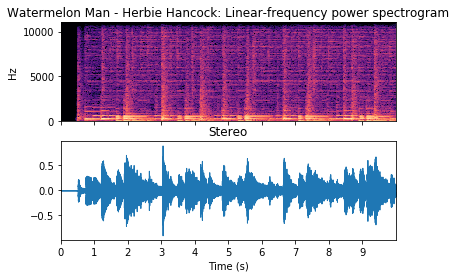

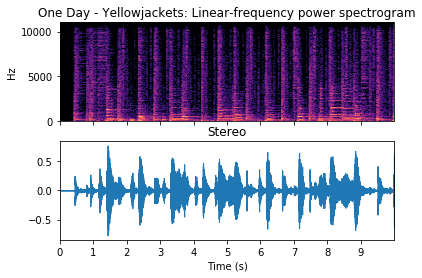

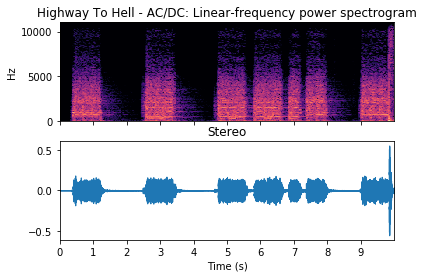

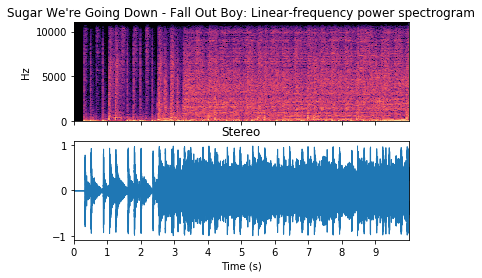

In [114]:
plot(watermelon_man, watermelon_man_sr, "Watermelon Man - Herbie Hancock:")
plot(one_day, one_day_sr, "One Day - Yellowjackets:")
plot(hth, hth_sr, "Highway To Hell - AC/DC:")
plot(sugar_down, sugar_down_sr, "Sugar We're Going Down - Fall Out Boy:")

### Calculate Beat Onsets

Jazz 

In [127]:
watermelon_man_otimes, watermelon_man_oclicks = onsets(watermelon_man, watermelon_man_sr)
one_day_otimes, one_day_oclick = onsets(one_day, one_day_sr)

In [128]:
wm_onsets = normalize(watermelon_man_otimes)
od_onsets = normalize(one_day_otimes)

In [129]:
wm_frame = metric_frame(wm_onsets)
od_frame = metric_frame(od_onsets)

In [130]:
deviations(wm_frame, od_frame)

([0.0,
  -0.029024943310657594,
  0.058049886621315175,
  0.168344671201814,
  0.3947392290249434],
 0.118421768707483)

Rock

In [131]:
hth_otimes, hth_oclicks = onsets(hth, hth_sr)
swgd_otimes, swgd_oclicks = onsets(sugar_down, sugar_down_sr)

In [132]:
hth_onsets = normalize(hth_otimes)
swgd_onsets = normalize(swgd_otimes)

In [133]:
hth_frame = metric_frame(hth_onsets)
swgd_frame = metric_frame(swgd_onsets)

In [134]:
deviations(hth_frame, swgd_frame)

([0.0,
  -0.04063492063492062,
  0.4411791383219954,
  0.4179591836734694,
  0.882358276643991],
 0.34017233560090704)